### Load Config

In [1]:
from yaml import load, Loader
from bunch import Bunch

stream = open("config.yaml", 'r')
config = Bunch(load(stream, Loader=Loader))

### Classification

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import get_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import shap
import random

SCORING = ['roc_auc', 'balanced_accuracy', 'f1_micro', 'average_precision', 'recall', 'precision']
PARAMETERS = {'n_estimators': [50, 100, 150], "max_features": ['sqrt', 'log2']}

SIGNAL_COMBOS = [['driver_behavior'], ['driver_behavior', 'vehicle_behavior'], 
            ['driver_behavior', 'vehicle_behavior', 'navi'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

LOGO = LeaveOneGroupOut()

def collect_scores(scoring, y_true, y_pred):
    scores_dict = dict()
    for scorer in scoring:
        s = get_scorer(scorer)
        scores_dict[scorer] = s._score_func(y_true, y_pred)
    return scores_dict

for window_size in config.window_sizes:
    for combo in SIGNAL_COMBOS:
        signal_string = ''
        can_data_features = []
        for signal in combo:
            signal_string += '_' + signal
            can_data_features.append(pd.read_parquet('out/can_data_features_{}_windowsize_{}s.parquet'.format(signal, window_size)))
        can_data_features = pd.concat(can_data_features, axis=1)
        can_data_features.loc[:, 'label'] = 0
        can_data_features.loc[(slice(None), 'above', slice(None)), 'label'] = 1

        can_data_features.replace(np.nan, 10e6, inplace=True)

        # drop below BAC level for binary classification
        can_data_features = can_data_features.drop('below', level=1)

        for scenario in ['highway', 'rural', 'town']:
            print('signals: {}, window size: {}s, scenario: {}'.format(signal_string, window_size, scenario))

            can_data_features_bin = can_data_features.loc[:, :, scenario, :]

            groups = list(can_data_features_bin.index.get_level_values('subject_id'))
            subject_ids = np.unique(groups)
            
            X = can_data_features_bin.drop(columns='label').to_numpy(dtype=np.float64)
            
            y = can_data_features_bin['label'].to_numpy()

            clf = None
            if config.classifier == 'log_regression':
                clf = LogisticRegression(
                penalty='l1', solver='liblinear', max_iter=1000, tol=1e-1, class_weight='balanced')
            elif config.classifier == 'random_forest':
                clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=3)
            
            #sfs = SequentialFeatureSelector(clf, n_features_to_select=5, scoring='roc_auc', n_jobs=len(subject_ids))

            pipeline = make_pipeline(StandardScaler(), clf)

            cv = cross_validate(estimator=pipeline, X=X, y=y, scoring=SCORING, return_estimator=True, verbose=0,
                    return_train_score=True, cv=LOGO, groups=groups, n_jobs=len(subject_ids))

            # for subject_id, est in zip(subject_ids, cv['estimator']):
            #     if not os.path.exists('out/results/subject_{}'.format(subject_id)):
            #         os.makedirs('out/results/subject_{}'.format(subject_id))
            #     RocCurveDisplay.from_estimator(est, X, y)
            #     plt.savefig('out/results/subject_{}/roc_curve_windowsize_{}{}_{}.png'.format(subject_id, window_size, signal_string, scenario))
            #     plt.close()

            # ind = random.choice(range(len(subject_ids)))
            # feature_names = can_data_features_bin.columns.to_list()[:-1]
            # explainer = shap.LinearExplainer(cv['estimator'][ind]['logisticregression'], X, feature_names=feature_names)
            # shap_values = explainer.shap_values(X)

            # shap_values = pd.DataFrame(shap_values)
            # shap_values.columns = feature_names
            # shap_values.set_index(can_data_features_bin.index).to_parquet(
            #     'out/shap_values_windowsize_{}{}_{}.parquet'.format(window_size, signal_string, scenario), index=True
            # )
            
            results = pd.DataFrame({k:v for k,v in cv.items() if k not in ['estimator']}).set_index(subject_ids)
            mean = results.mean(axis=0).rename('mean')
            std = results.std(axis=0).rename('stddev')
            results = results.append(mean)
            results = results.append(std)
            results.to_csv(
                    'out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index=True, header=True
                    )


signals: _driver_behavior, window size: 60s, scenario: highway
signals: _driver_behavior, window size: 60s, scenario: rural


### Visualize Results

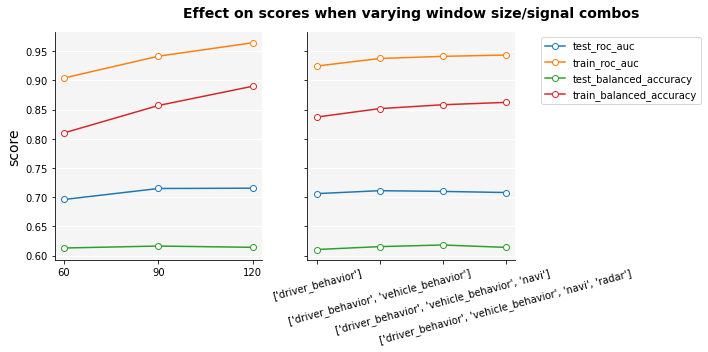

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior'], ['driver_behavior', 'vehicle_behavior'], 
            ['driver_behavior', 'vehicle_behavior', 'navi'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

fig, axes = putil.create_plot(nrows=1, ncols=2, sharey=True)
for ax in axes:
    putil.set_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 10, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for window_size in config.window_sizes:
    avg_mean_scores = []
    stddev = []
    for combo in SIGNAL_COMBOS:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', ['test_roc_auc', 'train_roc_auc', 'test_balanced_accuracy', 'train_balanced_accuracy']])
            stddev.append(results.loc['stddev', ['test_roc_auc', 'train_roc_auc', 'test_balanced_accuracy', 'train_balanced_accuracy']])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    stddev = np.array(stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
axes[0].plot(config.window_sizes, avg_scores, markerfacecolor='white', marker="o")
putil.set_plot_xticks(axes[0], config.window_sizes, config.window_sizes)
putil.set_ax_axis_labels(axes[0], y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_grid_lines(axes[0], True, axis="y", color="w")

# compare signal combos
avg_scores = []
avg_stddev = []
for combo in SIGNAL_COMBOS:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', ['test_roc_auc', 'train_roc_auc', 'test_balanced_accuracy', 'train_balanced_accuracy']])
            mean_stddev.append(results.loc['stddev', ['test_roc_auc', 'train_roc_auc', 'test_balanced_accuracy', 'train_balanced_accuracy']])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
axes[1].plot(range(len(avg_scores)), avg_scores, markerfacecolor='white', marker="o")
putil.set_plot_xticks(axes[1], range(len(avg_scores)), SIGNAL_COMBOS, rotation=15)
putil.set_ax_bg_color(axes[1], 'whitesmoke')
putil.set_grid_lines(axes[1], True, axis="y", color="w")

plt.legend(['test_roc_auc', 'train_roc_auc', 'test_balanced_accuracy', 'train_balanced_accuracy'], bbox_to_anchor=(1.1, 1.0))
putil.set_plot_title(title='Effect on scores when varying window size/signal combos', font_weight='bold', pad=15)
plt.tight_layout()
plt.savefig('out/results/{}_scores_varying_window_size_signal_combos.svg'.format(config.classifier))